In [257]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import seaborn as sn
import matplotlib.pyplot as plt

import torch

from datetime import date
from datetime import datetime


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [258]:
data = pd.read_csv(f'csv/train.csv')
data.head()

,id,Open Date,City Group,P1,P2,P6,P7,P11,P17,P21,P22,P28,revenue
0,0,0.819966,1.0,0.272727,0.615385,0.111111,0.444444,0.222222,0.133333,0.000000,0.50,0.086957,5653753.0
1,1,0.335651,1.0,0.272727,0.615385,0.111111,0.444444,0.000000,0.000000,0.000000,0.50,0.173913,6923131.0
2,2,0.049760,0.0,0.090909,0.461538,0.222222,0.444444,0.111111,0.000000,0.000000,0.00,0.000000,2055379.0
3,3,0.111729,0.0,0.454545,0.538462,0.333333,1.000000,0.777778,0.200000,0.357143,0.00,0.130435,2675511.0
4,4,0.266110,0.0,0.181818,0.461538,0.111111,0.444444,0.111111,0.066667,0.000000,0.25,0.000000,4316715.0


In [259]:
columns_len = data.columns.shape[0]

X = data.iloc[:, 0:columns_len - 1]
Y = data.iloc[:, columns_len - 1]

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8)

X_test.reset_index(inplace=True)
y_test = pd.DataFrame(y_test.values)

X_test.drop('index', axis=1, inplace=True)

In [261]:
X_train_torch = torch.from_numpy(X_train.values).float()
X_test_torch = torch.from_numpy(X_test.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_test_torch = torch.from_numpy(y_test.values).float()

In [322]:
model = torch.nn.Sequential(
        torch.nn.Linear(X_train_torch.shape[1], 100),
        torch.nn.Dropout(p=0.1),
        torch.nn.ReLU(),

        torch.nn.Linear(100, 200),
        torch.nn.Dropout(p=0.3),
        torch.nn.ReLU(),

        torch.nn.Linear(200, 150),
        torch.nn.Dropout(p=0.5),
        torch.nn.ReLU(),

        torch.nn.Linear(150, 50),
        torch.nn.Dropout(p=0.3),
        torch.nn.ReLU(),

        torch.nn.Linear(50, 1),
)

if torch.cuda.is_available():
    model = model.cuda()
    X_train_torch, y_train_torch = X_train_torch.cuda(), y_train_torch.cuda()
    X_test_torch, y_test_torch = X_test_torch.cuda(), y_test_torch.cuda()

criterion = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


loss_list = []
for epoch in range(1250):
    output = model(X_train_torch)

    loss = criterion(output,
                     torch.reshape(y_train_torch,(X_train_torch.shape[0], 1)))
    loss_list.append(loss.cpu().detach().numpy() )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

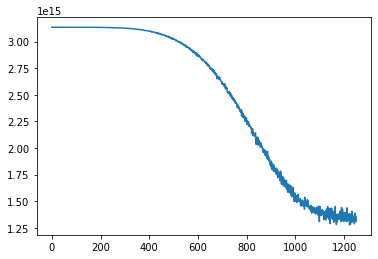

In [323]:
plt.plot(loss_list)
plt.show()

In [338]:
y_predict_test = model(X_test_torch).cpu().detach().numpy()
y = y_test_torch.cpu().detach().numpy()

mse = mean_squared_error(y, y_predict_test)
se = np.square(np.max(np.abs(y - y_predict_test)))

print(f'Torch Neural Regression:\n'
      f'RMSE:\t{np.sqrt(mse)}\n'
      f'Normalized MSE:\t{mse/se}')

Torch Тeural Кegression:
RMSE:	2746375.0
Normalized MSE:	0.13852572441101074


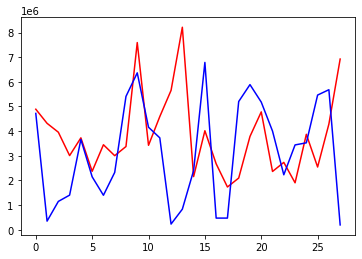

In [339]:
plt.plot(y, "red", y_predict_test, "blue")
plt.show()